In [1]:
import librosa
import os
import librosa.display
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
%matplotlib inline

In [2]:
from libs import utils, dataset, process, model

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [3]:
sampling_rate = 44100

In [6]:
wave = utils.get_music('dataset/fma_small/000/000002.mp3', sampling_rate)
wave = wave['2']

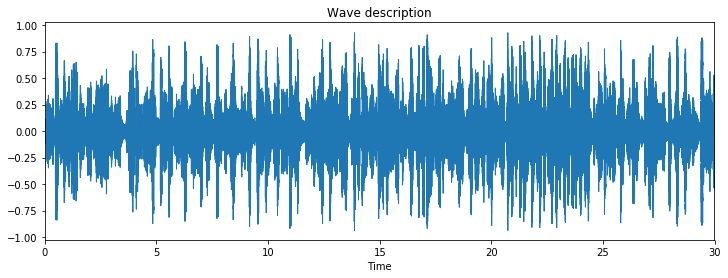

In [5]:
plt.figure(figsize=(12, 4))
librosa.display.waveplot(wave, sr=sampling_rate)
plt.title('Wave description')
plt.savefig('screenshots/Wave description.png')
plt.show()

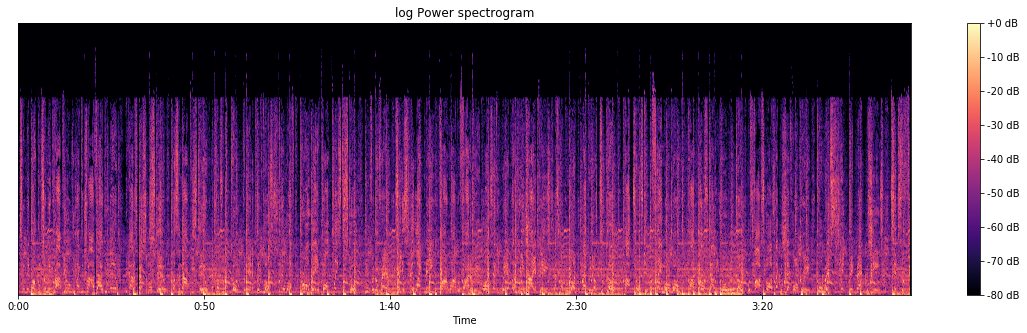

In [6]:
mag, phase = librosa.magphase(librosa.stft(wave, n_fft=2048, win_length=512))
wave_db = librosa.amplitude_to_db(mag, ref=np.max)
plt.figure(figsize=(20, 5))
librosa.display.specshow(wave_db, x_axis='time')
plt.title('log Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.savefig('screenshots/log Power spectrogram.png')
plt.show()

In [4]:
metadata_genre_file_path = './dataset/fma_metadata/tracks.csv'
subset = 'small'
utils.get_music_genre(metadata_genre_file_path, subset)
labels = pd.read_csv('preprocessing/train_labels.csv')
labels.head()

,track_id,genre
0,2,Hip-Hop
1,5,Hip-Hop
2,10,Pop
3,140,Folk
4,141,Folk


In [8]:
dataset_path = 'dataset/fma_small'
utils.get_all_music(dataset_path, labels, 20, 200)

Getting music files and converting it into spectrogram ...


file: 155066.mp3: 100%|██████████| 8000/8000 [1:09:41<00:00,  1.91it/s]


Spectrogram created


In [4]:
utils.slice_spectrograms("spectrograms", 198)

file: Hip-Hop/082780.png:   0%|          | 0/8 [00:00<?, ?it/s]

Slicing All Spectrograms


file: International/062527.png: 100%|██████████| 8/8 [01:57<00:00, 14.71s/it]

Spectrogram slice created


In [5]:
genres = utils.get_genre()

In [6]:
train_x, train_y, validation_x, \
validation_y, test_x, test_y = dataset.create_dataset_from_slices(2000, genres, 198, 0.15, 0.1)

-> Adding Hip-Hop...
-> Adding Pop...
-> Adding Folk...
-> Adding Experimental...
-> Adding Rock...
-> Adding International...
-> Adding Electronic...
-> Adding Instrumental...


In [7]:
classes = genres.shape[0]
genres

array(['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International',
       'Electronic', 'Instrumental'], dtype=object)

In [8]:
DNN_model = model.create_model(classes, 198)

Creating model...
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [ ]:
_id = process.train(DNN_model, train_x, train_y, validation_x, validation_y, 198, 20)

Training the model
---------------------------------
Run id: 8FZVCH
Log directory: ./tflearnLogs/
---------------------------------
Training samples: 12000
Validation samples: 2400
--


In [7]:
process.test(DNN_model, test_x, test_y, _id)

Loading weights...
INFO:tensorflow:Restoring parameters from /Users/shubham/Projects/machine-learning-projects/music-genre-classification/libs/../data/model/fmaDNN.tflearn
Weights loaded
Test accuracy: 0.73875 


In [8]:
y_pred = DNN_model.predict(test_x)
y_pred = y_pred.round()
y_pred

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [9]:
y_true = test_y 
y_true

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [11]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

array([[69,  8,  1,  2,  3,  3,  1,  1],
       [12, 84,  3,  0,  4,  3,  7,  2],
       [ 5,  4, 61,  6,  2,  1,  1,  5],
       [ 7,  4,  4, 74,  2,  7,  3,  5],
       [20,  3,  4,  0, 68,  2,  3,  1],
       [ 7,  0,  4,  2,  2, 78,  1,  3],
       [14,  1,  2,  4,  2,  2, 66,  5],
       [ 2,  5,  5,  5,  2,  2,  3, 88]])

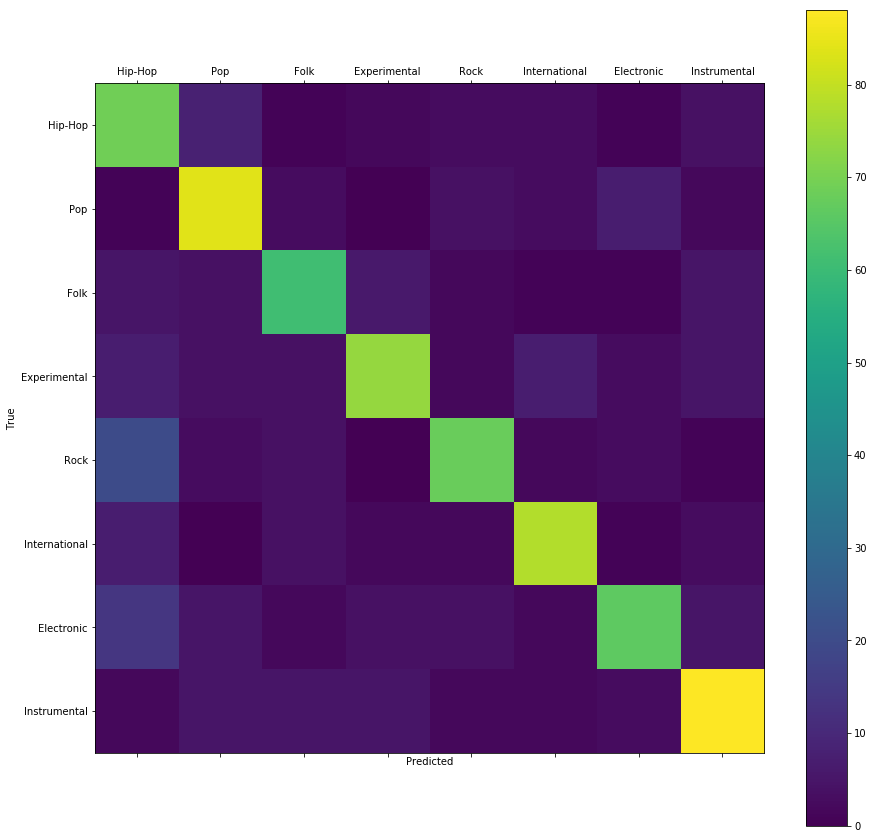

In [74]:
df_cm = pd.DataFrame(cm, index = [i for i in genres],
                  columns = [i for i in genres])
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
cax = ax.matshow(df_cm)
fig.colorbar(cax)
ax.set_xticks(np.arange(len(genres)))
ax.set_yticks(np.arange(len(genres)))
ax.set_xticklabels(genres)
ax.set_yticklabels(genres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('Confusion Matrix.png')
plt.show()

### Testing on new son

In [68]:
path = 'test/132042.mp3'
track_name = int(path.split("/")[-1].partition('.')[0])
utils.test_spectrogram(path)
utils.test_slice_('data/test/spectrograms/{:06d}/{:06d}.png'.format(track_name, track_name), 128)
test_music = dataset.create_test_dataset_from_slices('data/test/slice/{:06d}'.format(track_name), 128)   
test_music_pred = DNN_model.predict(test_music)
slice_prediction = test_music_pred
print(slice_prediction)
pred = slice_prediction.sum(axis=0)
print(pred)
pred_total = 0
for i in range(len(pred)):
    pred_total = pred_total + pred[i]
if pred[np.argmax(pred)] >= pred_total * 0.5:
    print(pred_total,pred[np.argmax(pred)], pred[np.argmax(pred)])
else:
    print(pred_total,pred[np.argmax(pred)], "Don't know")

[[3.3080381e-01 7.6651692e-02 4.1780964e-01 1.4647951e-02 2.8324630e-02
  8.5341409e-03 4.0611369e-03 1.1916703e-01]
 [1.4530307e-04 5.7727341e-03 2.8813320e-01 4.4441778e-02 2.7457576e-03
  8.5789748e-03 6.1317080e-01 3.7011441e-02]
 [5.1421171e-06 2.6012801e-03 7.0553482e-01 2.8646165e-01 1.4174929e-04
  3.8025041e-09 3.2351047e-03 2.0203011e-03]
 [1.1970403e-04 9.6037430e-01 3.0843180e-02 4.9774526e-03 6.5996830e-04
  2.4822786e-05 7.9744798e-04 2.2031623e-03]]
[0.331074   1.0454     1.4423208  0.35052884 0.0318721  0.01713794
 0.6212645  0.16040194]
4.00000018812716 1.4423208 Don't know


In [69]:
def find_genre(path, test_pred):
    track_name = int(path.split("/")[-1].partition('.')[0])
    utils.test_spectrogram(path)
    utils.test_slice_('data/test/spectrograms/{:06d}/{:06d}.png'.format(track_name, track_name), 128)
    test_music = dataset.create_test_dataset_from_slices('data/test/slice/{:06d}'.format(track_name), 128)   
    test_music_pred = DNN_model.predict(test_music)
    slice_prediction = test_music_pred
    pred = slice_prediction.sum(axis=0)
    pred_total = 0
    for i in range(len(pred)):
        pred_total = pred_total + pred[i]  
    weight_index = np.argmax(pred) 
    if pred[np.argmax(pred)] >= pred_total * 0.5:
        return track_name, genres[weight_index]
    else:
        return track_name, 'Dont Know'

In [70]:
test_music = [music for music in os.listdir('data/test') if music.endswith('.mp3')]
test_music = np.array(test_music)
test_music.shape

(110,)

In [80]:
test_pred = pd.DataFrame(columns=['track_id','genre'])
t = tqdm(test_music, desc='Bar desc', leave=True)
for music in t:
    try:
        track_name, genre = find_genre(os.path.join("data","test", music), test_pred)
        t.set_description("{:06d}.mp3 : {}".format(track_name, genre).ljust(40))
    except:
        pass
    test_pred = test_pred.append({'track_id': track_name, 'genre': genre}, ignore_index=True)
    t.refresh()

153337.mp3 : Dont Know                  : 100%|██████████| 110/110 [00:50<00:00,  2.20it/s]


In [74]:
test_pred2 = test_pred.loc[test_pred['genre'] != 'Dont Know']
test_pred2.shape

(56, 2)

In [75]:
test_true = pd.read_csv('data/train_labels.csv')
test_true.head()

,track_id,genre
0,2,Hip-Hop
1,5,Hip-Hop
2,10,Pop
3,140,Folk
4,141,Folk


In [76]:
def accuracy_precentage(test_true, test_pred):
    test_compare = pd.DataFrame(columns=['track_id','genre_true', 'genre_predicted'])
    correct = 0
    total = test_pred.shape[0]
    for index, row in test_pred.iterrows():
        track_id = row['track_id']
        genre_predicted = row['genre']
        genre_true = test_true.loc[test_true['track_id'] == track_id]['genre'].values[0]
        if (genre_true == genre_predicted):
            correct+=1
        test_compare = test_compare.append({'track_id': track_id, 'genre_true': genre_true,\
                                            'genre_predicted': genre_predicted}, ignore_index=True)   
    return correct/total, test_compare

In [78]:
accuracy, test_compare = accuracy_precentage(test_true, test_pred2)
accuracy

0.625

In [79]:
test_compare

,track_id,genre_true,genre_predicted
0,142551,Pop,Pop
1,142579,International,Hip-Hop
2,142949,Rock,Pop
3,142552,Pop,Pop
4,78998,Hip-Hop,Hip-Hop
5,142568,International,Hip-Hop
6,132139,International,International
7,142569,International,Hip-Hop
8,78839,Hip-Hop,Hip-Hop
9,142080,Electronic,Pop
